In [ ]:
# !mkdir -p cells
# !gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 malaria-cells cells

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow 
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
import os
from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
parasitized=0
allImages=[]
labels=[]
for dirname, _, filenames in os.walk('/content/cells/cell_images/Parasitized'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname,filename))
        # print(filename)
        
        if parasitized %1000==0:
            print(parasitized)
        if img is None :
            print('not img')
            continue
            
        img_resized = cv2.resize(img,(180, 180))
        allImages.append(img_resized)

        labels.append(1)
        parasitized+=1

print(len(allImages))
print(len(labels))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
13779
13779


In [ ]:
# print(len(parasitized))
uninfected=0
for dirname, _, filenames in os.walk('/content/cells/cell_images/Uninfected'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname,filename))
        # print(filename)
        
        if img is None :
            print('not img')
            continue
        if uninfected %1000==0:
            print(uninfected)
        img_resized = cv2.resize(img,(180, 180))#224
        
        allImages.append(img_resized)
        labels.append(0)
        uninfected+=1
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [ ]:
print(parasitized)
print(uninfected)
print(parasitized+uninfected)
print(len(allImages))
print(len(labels))

13779
13779
27558
27558
27558


In [ ]:
allImages = np.array(allImages)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

In [ ]:
#using all features
x_train, x_test, y_train, y_test = train_test_split(allImages, labels, test_size=0.25, random_state=2, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=2, stratify=y_train) 

In [ ]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
lrr= ReduceLROnPlateau(monitor='loss',   factor=0.5,   patience=3,  min_lr=1e-5) 
earlystop = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True) #

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(zoom_range=0.5,rotation_range=90,fill_mode='nearest',)
val_generator = ImageDataGenerator(zoom_range=0.5,rotation_range=90,fill_mode='nearest',)
# test_generator = ImageDataGenerator(zoom_range=0.5,rotation_range=90,fill_mode='nearest',)

In [ ]:
batch_size= 128 #110  
epochs=100 #10

### **CNN**

**Batch normalization** is a layer that allows every layer of the network to do learning more independently. It is used to normalize the output of the previous layers, it can be used as regularization to avoid overfitting of the model

**Dropouts** are added to randomly switching some percentage of neurons of the network, When the neurons are switched off the incoming and outgoing connection to those neurons is also switched off.

**Max pooling** is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output would be a feature map containing the most prominent features. Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network

In [ ]:
cnn=Sequential()

cnn.add(Conv2D(filters=96, input_shape=(180,180,3), kernel_size=(3,3), strides=(2,2), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))

cnn.add(Conv2D(filters=96, input_shape=(180,180,3), kernel_size=(5,5), strides=(2,2), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))

cnn.add(Conv2D(filters=165, input_shape=(180,180,3), kernel_size=(9,9), strides=(2,2), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))


cnn.add(Flatten())
cnn.add(Dense(580, input_shape=(180,180,3,)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.4))

cnn.add(Dense(1))
cnn.add(BatchNormalization())
cnn.add(Activation('sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 90, 90, 96)        2688      
                                                                 
 batch_normalization_5 (Batc  (None, 90, 90, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 90, 90, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 96)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 96)        230496    
                                                                 
 batch_normalization_6 (Batc  (None, 23, 23, 96)      

In [ ]:
cnn.compile(loss = keras.losses.binary_crossentropy, optimizer= 'adam', metrics=['accuracy']) # categorical_crossentropy adam 

In [ ]:
#Defining the parameters
batch_size= 128 #110  
epochs=100 #10

#Training the model 
history=cnn.fit(train_generator.flow(x_train, y_train, batch_size=batch_size), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size,  callbacks = [lrr,earlystop], verbose=1,validation_data=train_generator.flow(x_val, y_val))

Epoch 1/100
121/121 [==============================] - 192s 2s/step - loss: 0.4432 - accuracy: 0.8488 - val_loss: 0.6014 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 2/100
121/121 [==============================] - 187s 2s/step - loss: 0.3512 - accuracy: 0.9199 - val_loss: 0.4052 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - 186s 2s/step - loss: 0.3242 - accuracy: 0.9269 - val_loss: 0.3180 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 4/100
121/121 [==============================] - 186s 2s/step - loss: 0.3018 - accuracy: 0.9322 - val_loss: 0.3119 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 5/100
121/121 [==============================] - 187s 2s/step - loss: 0.2876 - accuracy: 0.9304 - val_loss: 0.3331 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 6/100
121/121 [==============================] - 187s 2s/step - loss: 0.2726 - accuracy: 0.9328 - val_loss: 0.2782 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 7/100
121/121 [==============================] - 187

In [ ]:
cnn.save('/content')

INFO:tensorflow:Assets written to: /content/assets


In [ ]:
predict_x=(cnn.predict(x_test) > 0.5).astype("int32")
pred=np.array(predict_x)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_mtx=confusion_matrix(y_test,pred)
print(confusion_mtx)
cr = classification_report(y_test, pred)
print("\n\nClassification Report\n")
print(cr)

[[3356   89]
 [ 140 3305]]


Classification Report

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3445
           1       0.97      0.96      0.97      3445

    accuracy                           0.97      6890
   macro avg       0.97      0.97      0.97      6890
weighted avg       0.97      0.97      0.97      6890



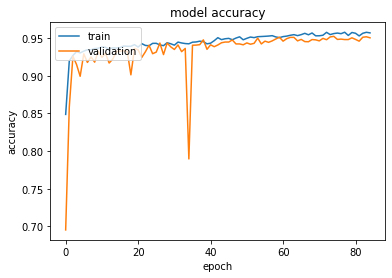

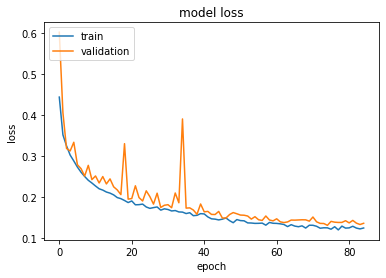

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **DenseNet**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.densenet import preprocess_input

In [ ]:
d=DenseNet121(weights='imagenet',include_top=False,pooling='max', input_shape=(180, 180, 3)) 

x=d.output
# x_pool = GlobalMaxPooling2D()(x)
preds=Dense(1,activation='sigmoid')(x)

In [ ]:
denseNet=Model(inputs=d.input,outputs=preds)
denseNet.summary()

In [ ]:
denseNet.input

<KerasTensor: shape=(None, 180, 180, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
for layer in denseNet.layers[:-8]:
    layer.trainable=False
    
for layer in denseNet.layers[-8:]:
    layer.trainable=True

In [ ]:
denseNet.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.summary()

In [ ]:
print(x_val.shape,y_val.shape)

(5167, 180, 180, 3) (5167,)


In [ ]:
#Defining the parameters
batch_size= 128 #110  
epochs=100 #10
learn_rate=0.01

#Training the model 
history=denseNet.fit(train_generator.flow(x_train, y_train, batch_size=batch_size), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size,  callbacks = [lrr,earlystop], verbose=1,validation_data=val_generator.flow(x_val, y_val),validation_steps=x_val.shape[0] / batch_size)

Epoch 1/100
121/121 [==============================] - 297s 2s/step - loss: 0.5488 - accuracy: 0.7449 - val_loss: 0.4453 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 2/100
121/121 [==============================] - 304s 3s/step - loss: 0.3894 - accuracy: 0.8355 - val_loss: 0.3256 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - 299s 2s/step - loss: 0.3317 - accuracy: 0.8669 - val_loss: 0.3128 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 4/100
121/121 [==============================] - 303s 3s/step - loss: 0.3119 - accuracy: 0.8797 - val_loss: 0.2949 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 5/100
121/121 [==============================] - 306s 3s/step - loss: 0.3051 - accuracy: 0.8827 - val_loss: 0.3046 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 6/100
121/121 [==============================] - 312s 3s/step - loss: 0.2803 - accuracy: 0.8943 - val_loss: 0.2890 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 7/100
121/121 [==============================] - 304

In [ ]:
denseNet.save('/content/dense')

INFO:tensorflow:Assets written to: /content/dense/assets


In [ ]:
predict_x=(denseNet.predict(x_test) > 0.5).astype("int32")
pred=np.array(predict_x)

confusion_mtx=confusion_matrix(y_test,pred)
print(confusion_mtx)
cr = classification_report(y_test, pred)
print("\n\nClassification Report\n")
print(cr)

[[3347   98]
 [ 305 3140]]


Classification Report

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3445
           1       0.97      0.91      0.94      3445

    accuracy                           0.94      6890
   macro avg       0.94      0.94      0.94      6890
weighted avg       0.94      0.94      0.94      6890



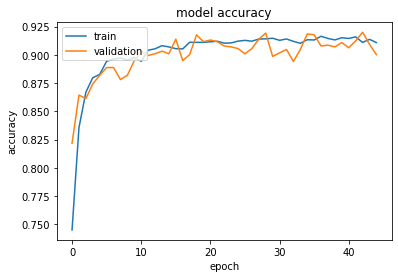

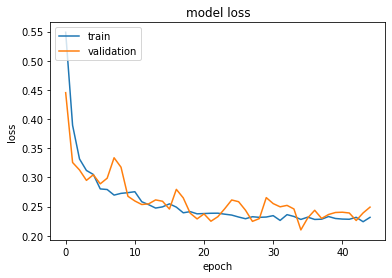

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **VGG19**

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.applications.vgg19 import VGG19

In [ ]:
# load model and specify a new input shape for images
# new_input = Input(shape=(180, 180, 3))
# model = VGG16(include_top=False, input_tensor=new_input,classes=2,weights='imagenet')
# -------------------------------
# re-size all the images to 180x180
IMAGE_SIZE = [180, 180,3] 

# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)


# create a model object
vgg19 = Model(inputs=vgg.input, outputs=prediction)

80150528/80134624 [==============================] - 2s 0us/step


In [ ]:
vgg19.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [ ]:
batch_size= 128 #110  
epochs=100 #10

vgg_history=vgg19.fit(train_generator.flow(x_train, y_train), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size,  
                callbacks = [lrr,earlystop], verbose=1,validation_data=val_generator.flow(x_val, y_val))

Epoch 1/100
121/121 [==============================] - 466s 4s/step - loss: 1.6739 - accuracy: 0.8094 - val_loss: 1.1424 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 2/100
121/121 [==============================] - 467s 4s/step - loss: 1.1996 - accuracy: 0.8715 - val_loss: 1.1722 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - 466s 4s/step - loss: 1.1781 - accuracy: 0.8740 - val_loss: 1.0140 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 4/100
121/121 [==============================] - 460s 4s/step - loss: 1.2973 - accuracy: 0.8698 - val_loss: 2.0897 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 5/100
121/121 [==============================] - 461s 4s/step - loss: 1.2608 - accuracy: 0.8714 - val_loss: 1.1035 - val_accuracy: 0.8872 - lr: 0.0010
Epoch 6/100
121/121 [==============================] - 457s 4s/step - loss: 1.2700 - accuracy: 0.8760 - val_loss: 1.4047 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 7/100
121/121 [==============================] - 456

In [ ]:
vgg19.save('/content/vgg')

INFO:tensorflow:Assets written to: /content/vgg/assets


In [ ]:
predict_x=(vgg19.predict(x_test) > 0.5).astype("int32")
pred=np.array(predict_x)

confusion_mtx=confusion_matrix(y_test,pred)
print(confusion_mtx)
cr = classification_report(y_test, pred)
print("\n\nClassification Report\n")
print(cr)

[[3265  180]
 [ 332 3113]]


Classification Report

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3445
           1       0.95      0.90      0.92      3445

    accuracy                           0.93      6890
   macro avg       0.93      0.93      0.93      6890
weighted avg       0.93      0.93      0.93      6890



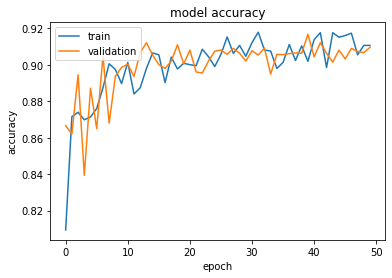

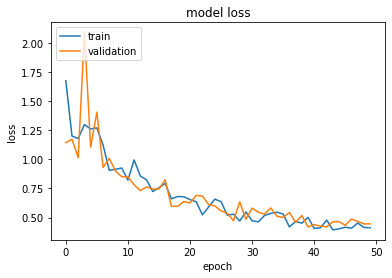

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **ResNet**

In [ ]:
from keras.applications.resnet import ResNet50

resnet = Sequential()
pretrained_model= ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet.add(pretrained_model)

resnet.add(Flatten())
# resnet.add(Dense(512, activation='relu'))
resnet.add(Dense(1, activation='sigmoid'))

In [ ]:
resnet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

resnet_history=resnet.fit(train_generator.flow(x_train, y_train), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size,  
                callbacks = [lrr,earlystop], verbose=1,validation_data=val_generator.flow(x_val, y_val))

Epoch 1/100
121/121 [==============================] - 169s 1s/step - loss: 0.7874 - accuracy: 0.7596 - val_loss: 0.5735 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 2/100
121/121 [==============================] - 169s 1s/step - loss: 0.4766 - accuracy: 0.8484 - val_loss: 0.3890 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - 166s 1s/step - loss: 0.3728 - accuracy: 0.8737 - val_loss: 0.3718 - val_accuracy: 0.8771 - lr: 0.0010
Epoch 4/100
121/121 [==============================] - 169s 1s/step - loss: 0.4181 - accuracy: 0.8691 - val_loss: 0.3389 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 5/100
121/121 [==============================] - 167s 1s/step - loss: 0.3845 - accuracy: 0.8809 - val_loss: 0.3389 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 6/100
121/121 [==============================] - 168s 1s/step - loss: 0.4119 - accuracy: 0.8753 - val_loss: 0.4233 - val_accuracy: 0.8746 - lr: 0.0010
Epoch 7/100
121/121 [==============================] - 168

In [ ]:
resnet.save('/content/resnet')

INFO:tensorflow:Assets written to: /content/resnet/assets


In [ ]:
predict_x=(resnet.predict(x_test) > 0.5).astype("int32")
pred=np.array(predict_x)

confusion_mtx=confusion_matrix(y_test,pred)
print(confusion_mtx)
cr = classification_report(y_test, pred)
print("\n\nClassification Report\n")
print(cr)

[[3313  132]
 [ 322 3123]]


Classification Report

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3445
           1       0.96      0.91      0.93      3445

    accuracy                           0.93      6890
   macro avg       0.94      0.93      0.93      6890
weighted avg       0.94      0.93      0.93      6890



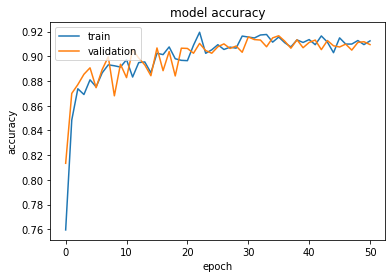

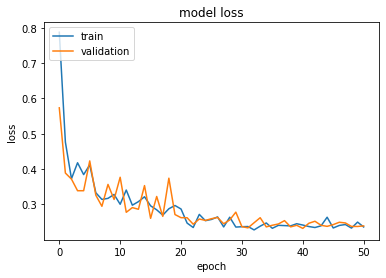

In [ ]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Inception V3**

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(180, 180,3))
base_model.trainable = False

# x = base_model.output
# out = Dense(1, activation="sigmoid")(x)

# our layers
x = Flatten()(base_model.output)
prediction = Dense(1, activation='sigmoid')(x)

inception = Model(inputs=base_model.input, outputs=prediction)


inception.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
inception_history=inception.fit(train_generator.flow(x_train, y_train), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, callbacks = [lrr,earlystop], verbose=1,
                                validation_data=val_generator.flow(x_val, y_val))

Epoch 1/100
121/121 [==============================] - 104s 830ms/step - loss: 15.6079 - accuracy: 0.6077 - val_loss: 9.2063 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 2/100
121/121 [==============================] - 99s 817ms/step - loss: 8.0783 - accuracy: 0.6519 - val_loss: 5.0880 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 3/100
121/121 [==============================] - 101s 837ms/step - loss: 10.8831 - accuracy: 0.6395 - val_loss: 8.6372 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 4/100
121/121 [==============================] - 101s 837ms/step - loss: 11.8553 - accuracy: 0.6619 - val_loss: 14.1651 - val_accuracy: 0.6394 - lr: 0.0010
Epoch 5/100
121/121 [==============================] - 101s 834ms/step - loss: 9.3393 - accuracy: 0.6767 - val_loss: 11.7769 - val_accuracy: 0.6921 - lr: 0.0010
Epoch 6/100
121/121 [==============================] - 100s 829ms/step - loss: 5.7609 - accuracy: 0.7265 - val_loss: 4.1302 - val_accuracy: 0.7469 - lr: 5.0000e-04
Epoch 7/100
121/121 [===========

In [ ]:
inception.save('/content/inception')

INFO:tensorflow:Assets written to: /content/inception/assets


In [ ]:
predict_x=(inception.predict(x_test) > 0.5).astype("int32")
pred=np.array(predict_x)

confusion_mtx=confusion_matrix(y_test,pred)
print(confusion_mtx)
cr = classification_report(y_test, pred)
print("\n\nClassification Report\n")
print(cr)

[[2819  626]
 [ 691 2754]]


Classification Report

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      3445
           1       0.81      0.80      0.81      3445

    accuracy                           0.81      6890
   macro avg       0.81      0.81      0.81      6890
weighted avg       0.81      0.81      0.81      6890



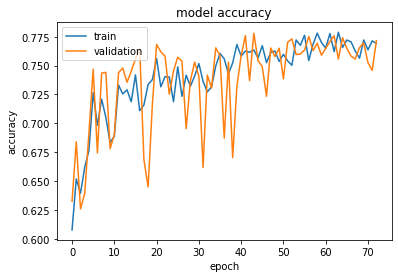

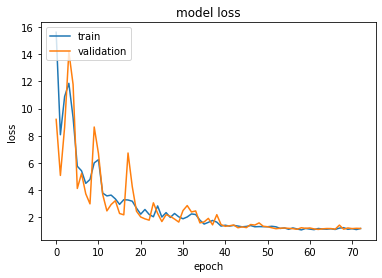

In [ ]:
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()